<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#======================================================" data-toc-modified-id="======================================================-1">======================================================</a></span></li><li><span><a href="#======================================================" data-toc-modified-id="======================================================-2">======================================================</a></span><ul class="toc-item"><li><span><a href="#-------------------------------------------------------------------------------------------------------------------" data-toc-modified-id="--------------------------------------------------------------------------------------------------------------------2.1">-------------------------------------------------------------------------------------------------------------------</a></span></li><li><span><a href="#Unconstraint-LS" data-toc-modified-id="Unconstraint-LS-2.2">Unconstraint LS</a></span></li><li><span><a href="#Sum-to-One-constraint-LS" data-toc-modified-id="Sum-to-One-constraint-LS-2.3">Sum-to-One constraint LS</a></span></li><li><span><a href="#Non-Negative-constraint-LS" data-toc-modified-id="Non-Negative-constraint-LS-2.4">Non-Negative constraint LS</a></span></li><li><span><a href="#Non-Negative-and-Sum-to-One-constraint-LS" data-toc-modified-id="Non-Negative-and-Sum-to-One-constraint-LS-2.5">Non-Negative and Sum-to-One constraint LS</a></span></li><li><span><a href="#LASSO-Regression" data-toc-modified-id="LASSO-Regression-2.6">LASSO Regression</a></span></li><li><span><a href="#Comments" data-toc-modified-id="Comments-2.7">Comments</a></span></li><li><span><a href="#Naive-Bayes" data-toc-modified-id="Naive-Bayes-2.8">Naive Bayes</a></span></li><li><span><a href="#K-Nearest-Neighbors" data-toc-modified-id="K-Nearest-Neighbors-2.9">K-Nearest Neighbors</a></span></li><li><span><a href="#Minimum-Euclidean-Distance-Classifier" data-toc-modified-id="Minimum-Euclidean-Distance-Classifier-2.10">Minimum Euclidean Distance Classifier</a></span></li><li><span><a href="#Bayesian-Classifier" data-toc-modified-id="Bayesian-Classifier-2.11">Bayesian Classifier</a></span></li><li><span><a href="#Comments" data-toc-modified-id="Comments-2.12">Comments</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.13">Conclusion</a></span></li></ul></li></ul></div>

## ======================================================

# Machine Learning and Computational Statistics Project

## ======================================================


# Process of Hyperspectral Images 
### -------------------------------------------------------------------------------------------------------------------

_________________________________________

In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LassoCV

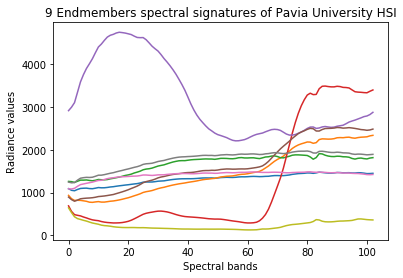

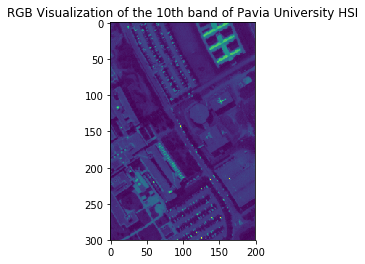

In [2]:
Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('PaviaU_ground_truth.mat')
labels=ground_truth['y']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

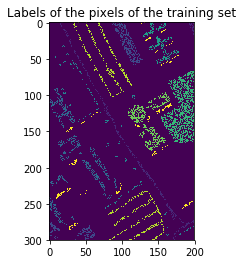

In [3]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('C:/Users/akaplanis/Desktop/MSc_Data_Science/Courses/2nd_Trimester/Machine_Learning/Assignments/Project/project/classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [4]:
#drop zero labels
HSI2 = HSI[labels > 0]

In [5]:
HSI2 = HSI2.T

# Part 1: Unmixing

---------------------------

### Unconstraint LS

In [6]:
#Least squares criterion
theta_est = np.zeros((9,len(HSI2[0])))

XTXinv = np.linalg.inv(np.dot(endmembers.T,endmembers))
theta_est =  np.dot(XTXinv,endmembers.T).dot(HSI2)

In [7]:
#calculate the reconstruction error
temp_array = HSI2 -  np.dot(endmembers,theta_est)

In [8]:
error = np.dot(temp_array.T,temp_array)

In [9]:
rec_error= np.zeros(len(error))

for i in range(len(rec_error)):
    rec_error[i] = error[i,i]


In [10]:
Unconstraint_Rec_Error = np.mean(rec_error)

In [11]:
print("The Reconstruction Error of the unconstraint LS is: ",Unconstraint_Rec_Error)

The Reconstruction Error of the unconstraint LS is:  118783.18062626586


In [12]:
#Abundance map
Uncontraint_Ab_Map = np.mean(theta_est, axis=1)

--------------------------------------------------------
### Sum-to-One constraint LS

<br>
<br>

Given that the model will have the following format:


\begin{equation*}
y = θ_1 x_1 + θ_2 x_2 + θ_3 x_3 + θ_4 x_4 + θ_5 x_5 + θ_6 x_6 + θ_7 x_7 + θ_8 x_8 + θ_9 x_9\quad\quad (1)
\end{equation*}

And since the coefficients will sum to one then they must satisfy the following equation:

\begin{equation*}
1 = θ_1 + θ_2 + θ_3 + θ_4 + θ_5 + θ_6 + θ_7 + θ_8 + θ_9
\end{equation*}

\begin{equation*}
<=>\quad θ_9 = 1 - (θ_1 + θ_2 + θ_3 + θ_4 + θ_5 + θ_6 + θ_7 + θ_8)\quad\quad (2)
\end{equation*}

As a result, through (1) and (2) we'll get:

\begin{equation*}
(1), (2)=>\quad y = θ_1 x_1 + θ_2 x_2 + θ_3 x_3 + θ_4 x_4 + θ_5 x_5 + θ_6 x_6 + θ_7 x_7 + θ_8 x_8 + [1 - (θ_1 + θ_2 + θ_3 + θ_4 + θ_5 + θ_6 + θ_7 + θ_8)] x_9
\end{equation*}

\begin{equation*}
<=> \quad y = θ_1 x_1 + θ_2 x_2 + θ_3 x_3 + θ_4 x_4 + θ_5 x_5 + θ_6 x_6 + θ_7 x_7 + θ_8 x_8 + x_9 - θ_1 x_9 - θ_2 x_9 - θ_3 x_9 - θ_4 x_9 - θ_5 x_9 - θ_6 x_9 - θ_7 x_9 - θ_8 x_9
\end{equation*}

\begin{equation*}
<=>\quad y-x_9 = θ_1 (x_1-x_9) + θ_2 (x_2-x_9) + θ_3 (x_3-x_9) + θ_4 (x_4-x_9) + θ_5 (x_5-x_9) + θ_6 (x_6-x_9) + θ_7 (x_7-x_9) + θ_8 (x_8-x_9) \quad\quad (3)
\end{equation*}

In [13]:
#create new Xs as seen in (3)
X_1 = endmembers[:,:-1] - endmembers[:,-1:]

In [14]:
#transform Y as seen in (3)

Y_1 = np.zeros((len(HSI2),len(HSI2[0])))

for i in range(len(HSI2[0])):
    Y_1[:,i] = HSI2[:,i] - endmembers[:,-1]


In [15]:
theta_est_1 = np.zeros((9,len(HSI2[0])))

XTXinv_1 = np.linalg.inv(np.dot(X_1.T,X_1))
theta_est_1 =  np.dot(XTXinv_1,X_1.T).dot(Y_1)

In [16]:
#apply the constraint by adding θ9

theta_est_2= np.zeros((9,12829))

for i in range(len(theta_est_1[0])):
     theta_est_2[:,i] = np.append(theta_est_1[:,i],1-np.sum(theta_est_1[:,i]))

In [17]:
#calculate the reconstruction error
temp_array_1 = HSI2 -  np.dot(endmembers,theta_est_2)

error_1 = np.dot(temp_array_1.T,temp_array_1)

rec_error_1= np.zeros(len(error_1))

for i in range(len(rec_error_1)):
    rec_error_1[i] = error_1[i,i]


In [18]:
SSO_Rec_Error = np.mean(rec_error_1)

print("The Reconstruction Error of the sum-to-one LS is: ",SSO_Rec_Error)

The Reconstruction Error of the sum-to-one LS is:  160049.93061911035


In [19]:
#Abundance map
Sum_to_One_Ab_Map = np.mean(theta_est_2, axis=1)

<br>

--------------------------------------------------------
### Non-Negative constraint LS

<br>

In [20]:
#apply the non negative constraint on the LS criterion

nnLS1 = ()

for i in range(len(HSI2[0])):
    nnLS1 += scipy.optimize.nnls(endmembers, HSI2[:,i])

In [21]:
coeffs11 = np.array(nnLS1[0::2])
coeffs11 = coeffs11.T

In [22]:
#calculate the reconstruction error
temp_array_7 = HSI2 -  np.dot(endmembers,coeffs11)

error_7 = np.dot(temp_array_7.T,temp_array_7)

rec_error_7= np.zeros(len(error_7))

for i in range(len(rec_error_7)):
    rec_error_7[i] = error_7[i,i]

In [23]:
NNLS_Rec_Error = np.mean(rec_error_7)

print("The Reconstruction Error of the non-negative LS is: ",NNLS_Rec_Error)

The Reconstruction Error of the non-negative LS is:  569339.2910564167


In [24]:
#Abundance map
Non_Negative_tAb_Map = np.mean(nnLS1[0::2], axis=0)


<br>

--------------------------------------------------------
### Non-Negative and Sum-to-One constraint LS

<br>
<br>

For this solution, given that the coefficients cannot be negative, I will follow the same practice as in the sum-to-one constraint (3) but with the addition of an extra dummy independent variable.<br><br>
Given that this variable is a dummy it won't matter if its coefficient is negative or not.
<br> 
As a result, it will act as regulator, keeping the sum of coefficients to one and above zero 

Effectively, I'll derive the following condition, using (3):

\begin{equation*}
y +1 -x_{10} = θ_1 (x_1-x_{10}) + θ_2 (x_2-x_{10}) + θ_3 (x_3-x_{10}) + θ_4 (x_4-x_{10}) + θ_5 (x_5-x_{10}) + θ_6 (x_6-x_{10}) + θ_7 (x_7-x_{10}) + θ_8 (x_8-x_{10}) + θ_9 (x_9-x_{10}) \quad\quad (4)
\end{equation*}

\begin{equation*}
where \quad x_{10} = [1, 1, ...1]
\end{equation*}

In [25]:
ones = np.ones(len(endmembers))

X1 = np.column_stack((endmembers,ones))
Y1 = np.column_stack((HSI2,ones))

In [26]:
X2 = X1[:,:-1] - X1[:,-1:]

In [27]:
nnLS2 = ()

for i in range(len(HSI2[0])):
    nnLS2 += scipy.optimize.nnls(X2, (HSI2[:,i]+ ones) - X1[:,-1])

In [28]:
coeffs = nnLS2[0::2]

In [29]:
u = [1-sum(i) for i in coeffs]

thetas =tuple((*i, j) for i, j in zip(coeffs,u))

In [30]:
thetas = np.array(thetas)
thetas = thetas.T

In [31]:
#calculate the reconstruction error
temp_array_8 = HSI2 -  np.dot(X1,thetas)

error_8 = np.dot(temp_array_8.T,temp_array_8)

rec_error_8= np.zeros(len(error_8))

for i in range(len(rec_error_8)):
    rec_error_8[i] = error_8[i,i]

In [32]:
NNLS_Rec_Error2 = np.mean(rec_error_8)

print("The Reconstruction Error of the non-negative and sum-to-one LS is: ",NNLS_Rec_Error2)

The Reconstruction Error of the non-negative and sum-to-one LS is:  569390.4312836744


In [33]:
#Abundance map
Non_Negative_Sum_to_One_Ab_Map = np.mean(nnLS2[0::2], axis=0)

<br>

----------------------------------------

### LASSO Regression


In [ ]:
Lasso = []

for i in range(len(HSI2[0])):
    Lasso += [linear_model.Lasso(alpha=1.5,fit_intercept = False).fit(endmembers, HSI2[:,i])]


In [35]:
#calculate the reconstruction error
temp_array_2 = np.zeros((103, len(HSI2[0])))

for i in range(len(HSI2[0])):
    temp_array_2[:,i] = HSI2[:,i] -  np.dot(endmembers,Lasso[i].coef_)

In [36]:

error_2 = np.dot(temp_array_2.T,temp_array_2)

rec_error_2= np.zeros(len(error_2))

for i in range(len(rec_error_2)):
    rec_error_2[i] = error_2[i,i]


In [37]:
LASSO_Rec_Error = np.mean(rec_error_2)

print("The Reconstruction Error of the LASSO regression is: ",LASSO_Rec_Error)

The Reconstruction Error of the LASSO regression is:  206154.4241147516


In [38]:
#Abundance map

h=np.zeros(9)
for i in range(len(Lasso)):
    h += Lasso[i].coef_

Lasso_Ab_Map = h/len(Lasso)

------------------------------------------------------
### Comments

In [39]:
Y_true = labels[labels>0]

In [40]:
# Mean of all the calculated thetas per model
Uncontraint_thetas = np.mean(theta_est, axis=1)

Sum_to_One_thetas = np.mean(theta_est_2, axis=1)

Non_Negative_thetas = np.mean(nnLS1[0::2], axis=0)

Non_Negative_Sum_to_One_thetas = np.mean(nnLS2[0::2], axis=0)

h=np.zeros(9)
for i in range(len(Lasso)):
    h += Lasso[i].coef_

Lasso_thetas = h/len(Lasso)

unique, counts = np.unique(Y_true, return_counts=True)
dict(zip(unique, counts))

True_Labels = counts/sum(counts)

In [41]:
print("\nUnconstraint LS\n\n", Uncontraint_thetas, "\n\n---",Unconstraint_Rec_Error)
print("\n___________________________\nSum to One LS\n\n", Sum_to_One_thetas, "\n\n---",SSO_Rec_Error)
print("\n___________________________\nNon Negative LS\n\n", Non_Negative_thetas, "\n\n---",NNLS_Rec_Error)
print("\n___________________________\nNon Negative & Sum to One LS\n\n", Non_Negative_Sum_to_One_thetas, "\n\n---",NNLS_Rec_Error2)
print("\n___________________________\nLasso Regression\n\n", Lasso_thetas, "\n\n---",LASSO_Rec_Error)
print("\n___________________________\nTrue Labels\n", True_Labels)



Unconstraint LS

 [0.08636683 0.10733494 0.16361369 0.04747057 0.05440798 0.23711903
 0.10367137 0.13991737 0.06009821] 

--- 118783.18062626586

___________________________
Sum to One LS

 [0.08636683 0.10733494 0.16361369 0.04747057 0.05440798 0.23711903
 0.10367137 0.13991737 0.06009821] 

--- 160049.93061911035

___________________________
Non Negative LS

 [0.01544446 0.14266496 0.2196971  0.09080512 0.05854438 0.10383585
 0.16048559 0.14763375 0.11156595] 

--- 569339.2910564167

___________________________
Non Negative & Sum to One LS

 [0.01547453 0.14270264 0.21986821 0.09076014 0.05856662 0.10387349
 0.16085761 0.14760934 0.11193732] 

--- 569390.4312836744

___________________________
Lasso Regression

 [ 1.21576226  0.14417982 -0.07523955  0.10927481  0.03675384 -0.01618733
 -0.24844802  0.05655186 -0.37574831] 

--- 206154.4241147516

___________________________
True Labels
 [0.08636683 0.10733494 0.16361369 0.04747057 0.05440798 0.23711903
 0.10367137 0.13991737 0.060098

It is apparent that the unconstraint LS and the LS with the sum-to-one overfit to the model, giving thus, the exact same abundance maps.

Also, it can be noticed that the more the constraints the more is the reconstruction error being raised. However the Non-negative and Sum-to-One constraint LS is effectively treated as a NNLS.

As a result, I would either prefer the LS with the non-negative and sum-to-one constraints for the unmixing, at the expense of a high reconstruction error but with an adequately accurate abundance map or LASSO with a smaller reconstruction error but less accurate abundance map.

# Part 2: Classification

In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import multivariate_normal

In [43]:
kfold = model_selection.KFold(n_splits=10)

In [44]:
X_train = HSI[Training_Set > 0]
y_train = Training_Set[Training_Set > 0]
y_train = y_train.reshape(y_train.shape[0],)

X_test = HSI[Test_Set > 0]
y_test = Test_Set[Test_Set > 0]
y_test = y_test.reshape(y_test.shape[0], )

y_oper = Operational_Set[Operational_Set>0]

-----------------------------------------------------

### Naive Bayes

In [45]:
#train naive bayes classifier

NB = GaussianNB()
NBayes = NB.fit(X_train, y_train)

In [46]:
#appsly 10-fold validation
NB_kfold = model_selection.cross_val_score(NBayes, X_train, y_train, cv=kfold)

In [47]:
# Accuracy and standard deviation
NB_accuracy = round(NB_kfold.mean()*100,2)

NB_std = round(NB_kfold.std()*100,2)

print("Accuracy: ",NB_accuracy, "%\n\nStandard Deviation: ",NB_std,"%" )

Accuracy:  59.09 %

Standard Deviation:  15.82 %


In [48]:
NB_y_pred = NB.fit(X_train, y_train).predict(X_test)

In [49]:
#confusion matrix for the naive bayes classifier
NB_CM = confusion_matrix(y_test,NB_y_pred)

In [50]:
#normalization of the confusion matrix
NB_CM_rows = np.sum(NB_CM, axis=1)

NB_CM_Nrm = np.zeros((9,9))

for i in range(9):
    for j in range(9):
        NB_CM_Nrm[i,j] = NB_CM[i,j]/NB_CM_rows[i]

In [51]:
NB_CM_Nrm = np.around(NB_CM_Nrm,2)
print(NB_CM_Nrm)

[[0.5  0.   0.14 0.   0.   0.   0.31 0.05 0.  ]
 [0.   0.92 0.01 0.02 0.   0.05 0.   0.   0.  ]
 [0.05 0.   0.24 0.   0.   0.02 0.13 0.56 0.  ]
 [0.   0.   0.   0.99 0.01 0.01 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.99 0.01 0.   0.   0.  ]
 [0.   0.41 0.   0.07 0.04 0.48 0.   0.   0.  ]
 [0.06 0.   0.08 0.   0.   0.   0.86 0.   0.  ]
 [0.   0.   0.15 0.   0.   0.   0.   0.84 0.  ]
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.99]]


In [52]:
#Success Rate calculation
Σ_matrix_NB = np.sum(NB_CM)
DiagonalCM_NB=0


for i in range(len(NB_CM[0])):
     DiagonalCM_NB += NB_CM[i,i]

Success_Rate_NB = (DiagonalCM_NB/Σ_matrix_NB)*100
Success_Rate_NB= round(Success_Rate_NB,2)
print("The Success Rate for the Naive Bayes classifier is",Success_Rate_NB,"%")

The Success Rate for the Naive Bayes classifier is 66.01 %


### K-Nearest Neighbors

In [53]:
#train KNN classifier
KNN = KNeighborsClassifier(n_neighbors=11)
KNearNeg = KNN.fit(X_train, y_train)

In [54]:
#apply 10-fold validation
KNN_kfold = model_selection.cross_val_score(KNearNeg, X_train, y_train, cv=kfold)

In [55]:
# Accuracy and standard deviation
KNN_accuracy = round(KNN_kfold.mean()*100,2)

KNN_std = round(KNN_kfold.std()*100,2)

print("Accuracy: ",KNN_accuracy, "%\n\nStandard Deviation: ",KNN_std,"%" )

Accuracy:  76.53 %

Standard Deviation:  15.07 %


In [56]:
ΚΝΝ_y_pred = KNN.fit(X_train, y_train).predict(X_test)

In [57]:
#confusion matrix for the KNN classifier
ΚΝΝ_CM = confusion_matrix(y_test,ΚΝΝ_y_pred)

In [58]:
#normalization of the confusion matrix
ΚΝΝ_CM_rows = np.sum(ΚΝΝ_CM, axis=1)

ΚΝΝ_CM_Nrm = np.zeros((9,9))

for i in range(9):
    for j in range(9):
        ΚΝΝ_CM_Nrm[i,j] = ΚΝΝ_CM[i,j]/ΚΝΝ_CM_rows[i]

In [59]:
ΚΝΝ_CM_Nrm = np.around(ΚΝΝ_CM_Nrm,2)
print(ΚΝΝ_CM_Nrm)

[[0.72 0.   0.06 0.   0.   0.   0.11 0.11 0.  ]
 [0.   0.91 0.   0.   0.   0.08 0.   0.   0.  ]
 [0.02 0.   0.84 0.   0.   0.01 0.   0.13 0.  ]
 [0.   0.01 0.   0.99 0.   0.01 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.99 0.   0.   0.01 0.  ]
 [0.   0.09 0.   0.   0.   0.91 0.   0.   0.  ]
 [0.04 0.   0.02 0.   0.   0.   0.94 0.01 0.  ]
 [0.02 0.   0.19 0.   0.   0.   0.   0.78 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


In [60]:
#Success Rate calculation
Σ_matrix_ΚΝΝ = np.sum(ΚΝΝ_CM)
DiagonalCM_ΚΝΝ=0


for i in range(len(ΚΝΝ_CM[0])):
     DiagonalCM_ΚΝΝ += ΚΝΝ_CM[i,i]

Success_Rate_ΚΝΝ = (DiagonalCM_ΚΝΝ/Σ_matrix_ΚΝΝ)*100
Success_Rate_ΚΝΝ= round(Success_Rate_ΚΝΝ,2)
print("The Success Rate for the K Nearest Neighbors classifier is",Success_Rate_ΚΝΝ,"%")

The Success Rate for the K Nearest Neighbors classifier is 88.0 %


### Minimum Euclidean Distance Classifier


For the minimum euclidean distance classifier we assume that each class follows a normal distribution. <br> 
Additionally it is assumed that:<br>
1. all 9 classes have equal covariance matrices which in turn equal to σ^2*Ι
<br> and<br>
2. the classes are equiprobable


In [61]:
def min_eucl_clf(X,X_train,Y_train):
    
    #examine the classes of the dataset
    index = np.zeros((len(Y_train), 9))

    for i in range(9):
        index[:,i] = (Y_train==i+1).reshape(len(Y_train))

    index = index.astype(int)

    #find the mean of all 103 rows for each class
    class_means = np.zeros((103,9))

    for i in range(9):
        class_means[:,i] = np.mean(X_train[index[:,i]==1,:], axis=0)
    
    
    #calculate the euclidean distance
    u = np.zeros((len(X),9))
    m = np.zeros((len(X)))

    for k in range(len(X)):
        for i in range(9):
            for j in range(103):
                u[k,i] =  np.sqrt(np.sum((X[k,j]-class_means[j,i])**2))
    
    #classification rule
    w = np.min(u, axis=1)
    
    #find the class of each row
    for i in range(len(X)):
        m[i] = np.array(np.where(u[i,:] == w[i])) + 1 #plus 1 to avoid starting from position 0
    
    m = m.astype(int)
         
    return m

In [62]:
Eucl_y_pred = min_eucl_clf(X_test,X_train,y_train)

K-fold cross-validation requires splitting the training dataset to k-parts. This way the  model is trained using k-1 parts as the training dataset and the remaining one as the test.<br>
This goes on until all 10 datasets have played the part of the test set.

In [63]:

def cross_validation(datasetX,datasetY, folds=10):
    
    length = len(datasetX)-len(datasetX)%folds  #drop remainder rows
    testsetX = np.array(np.vsplit(datasetX[0:length],folds))
    dummyY = np.array(np.split(datasetY[0:length],folds))
    
    test_length = int(length/folds)
    train_length = int(length - test_length)
    
    trainsetX = np.zeros((folds,folds-1,test_length,103))
    trainsetY = np.zeros((folds,folds-1,test_length))
    #trainset = np.zeros((10,9,641,103))
    for i in range(9):  #iterate 8 times
        v = i+1
        u = i+2
        trainsetX[i,:,:,:] = np.vstack((testsetX[0:v,:,:],testsetX[u:,:,:]))
        trainsetY[i,:,:] = np.vstack((dummyY[0:v,:],dummyY[u:,:]))
        
    trainsetX[folds-1,:,:,:] = testsetX[1:,:,:] #final iteration
    trainsetY[folds-1,:,:] = dummyY[1:,:] #final iteration
    
    trainsetX2 = trainsetX.reshape((folds,(folds-1)*test_length,103))
    trainsetY2 = trainsetY.reshape((folds,(folds-1)*test_length))
    
    #trainset indices: 0-8 match with testset indices: 1:9 respectively
    #and trainset index: 9 match with testset index: 0
    
    q = np.zeros((folds,test_length))
    
    for i in range(9): #9 iterations
        q[i,:] = min_eucl_clf(testsetX[i+1],trainsetX2[i],trainsetY2[i])
    
    q[folds-1,:] = min_eucl_clf(testsetX[0],trainsetX2[folds-1],trainsetY2[folds-1]) #correction for the indices
    
    #trainset indices: 0-8 match with testset indices: 1:9 respectively
    #and trainset index: 9 match with testset index: 0
    
    kfold_Eucl_CM = np.zeros((folds,9,9))
   
    for i in range(9): #9 iterations
        kfold_Eucl_CM[i,:,:] = confusion_matrix(dummyY[i+1],q[i])
    
    kfold_Eucl_CM[folds-1,:,:] = confusion_matrix(dummyY[0],q[folds-1]) #correction for the indices

    Σ_matrix_kEucl =np.zeros((folds,1))
    DiagonalCM_kEucl= np.zeros((folds,1))
    Success_Rate_kEucl= np.zeros((folds,1))

    for j in range(folds):
        for i in range(9):
             DiagonalCM_kEucl[j,] += kfold_Eucl_CM[j,i,i]
            
        Σ_matrix_kEucl[j,] = np.sum(kfold_Eucl_CM[j,:,:])     
        Success_Rate_kEucl[j,] = (DiagonalCM_kEucl[j,]/Σ_matrix_kEucl[j,])

    
    
    return Success_Rate_kEucl
    

In [64]:
Eucl_kfold = cross_validation(X_train,y_train,10)

In [65]:
# Accuracy and standard deviation
Eucl_accuracy = round(np.mean(Eucl_kfold)*100,2)
Eucl_std = round(np.std(Eucl_kfold)*100,2)

print("Accuracy: ",Eucl_accuracy, "%\n\nStandard Deviation: ",Eucl_std,"%" )

Accuracy:  47.16 %

Standard Deviation:  11.03 %


In [66]:
#confusion matrix for the Min. Euclidean Dist. classifier
Eucl_CM = confusion_matrix(y_test,Eucl_y_pred)

In [67]:
#normalization of the confusion matrix
Eucl_CM_rows = np.sum(Eucl_CM, axis=1)

Eucl_CM_Nrm = np.zeros((9,9))

for i in range(9):
    for j in range(9):
        Eucl_CM_Nrm[i,j] = Eucl_CM[i,j]/Eucl_CM_rows[i]

In [68]:
Eucl_CM_Nrm = np.around(Eucl_CM_Nrm,2)
print(Eucl_CM_Nrm)

[[0.32 0.   0.23 0.   0.   0.   0.44 0.02 0.  ]
 [0.   0.7  0.   0.01 0.03 0.25 0.   0.01 0.  ]
 [0.15 0.07 0.39 0.   0.   0.   0.03 0.36 0.  ]
 [0.01 0.07 0.   0.65 0.17 0.1  0.   0.   0.  ]
 [0.   0.09 0.02 0.36 0.17 0.12 0.   0.24 0.  ]
 [0.   0.25 0.02 0.03 0.19 0.44 0.   0.07 0.  ]
 [0.39 0.   0.03 0.   0.   0.   0.58 0.   0.  ]
 [0.01 0.01 0.32 0.   0.   0.   0.   0.65 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


In [69]:
#Success Rate calculation
Σ_matrix_Eucl = np.sum(Eucl_CM)
DiagonalCM_Eucl=0


for i in range(len(Eucl_CM[0])):
     DiagonalCM_Eucl += Eucl_CM[i,i]

Success_Rate_Eucl = (DiagonalCM_Eucl/Σ_matrix_Eucl)*100
Success_Rate_Eucl= round(Success_Rate_Eucl,2)
print("The Success Rate for the Minimum Euclidean Distance classifier is",Success_Rate_Eucl,"%")

The Success Rate for the Minimum Euclidean Distance classifier is 52.45 %


### Bayesian Classifier

For the Bayesian classifier I will assume that each class follows a 103-d normal distribution, since I could not make the non-parametric method (k-nn density function) work.

In [70]:
#formulation of the classifier

def Bayes_clf(X, X_train, Y_train):
        
    #examine the classes of the dataset
    index = np.zeros((len(Y_train), 9))

    for i in range(9):
        index[:,i] = (Y_train==i+1).reshape(len(Y_train))

    index = index.astype(int)
    
    N = len(Y_train)

    N_class = np.sum(index, axis=0)
    
    #calculation of the a priori probabilities

    P_class = np.zeros(9)

    for i in range(9):
        P_class[i] = N_class[i]/N

    #find the mean of all 103 rows for each class
    class_means = np.zeros((103,9))

    for i in range(9):
        class_means[:,i] = np.mean(X_train[index[:,i]==1,:], axis=0)
    
    #calculation of the variance matrices
    S= np.zeros((9,103,103))

    for i in range(9):
        class100 = X_train[index[:,i]==1]
        mean_class100 = np.tile(class_means[:,i],(len(X_train[index[:,i]==1]),1))
        S[i,:,:] = (1/len(class100))*(np.dot((mean_class100-class100).T,(mean_class100-class100)))
        

    d = np.zeros((len(X),9))  
    m = np.zeros((len(X))) 

    for i in range(9):
        d[:,i] = multivariate_normal(class_means[:,i],S[i]).pdf(X)*P_class[i]

    #classification rule
    w = np.max(d, axis=1)
    
    #find the class of each row
    for i in range(len(X)):
        m[i] = sum(np.where(d[i,:] == w[i]) , 1) #plus 1 to avoid starting from position 0
    
    m = m.astype(int)
         
    return m

In [71]:
Bayes_y_pred = Bayes_clf(X_test,X_train,y_train)

In [72]:
#confusion matrix for the Bayesian classifier
Bayes_CM = confusion_matrix(y_test,Bayes_y_pred)

In [73]:
#normalization of the confusion matrix
Bayes_CM_rows = np.sum(Bayes_CM, axis=1)

Bayes_CM_Nrm = np.zeros((9,9))

for i in range(9):
    for j in range(9):
        Bayes_CM_Nrm[i,j] = Bayes_CM[i,j]/Bayes_CM_rows[i]

In [74]:
Bayes_CM_Nrm = np.around(Bayes_CM_Nrm,2)
print(Bayes_CM_Nrm)

[[0.59 0.   0.18 0.   0.   0.01 0.04 0.18 0.  ]
 [0.   0.93 0.   0.01 0.   0.06 0.   0.   0.  ]
 [0.02 0.   0.8  0.   0.   0.   0.   0.18 0.  ]
 [0.   0.   0.   0.99 0.   0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.04 0.   0.03 0.   0.   0.01 0.91 0.01 0.  ]
 [0.04 0.   0.16 0.   0.   0.   0.   0.8  0.  ]
 [0.02 0.   0.   0.01 0.01 0.   0.   0.   0.97]]


In [75]:
#Success Rate calculation
Σ_matrix_Bayes = np.sum(Bayes_CM)
DiagonalCM_Bayes=0


for i in range(len(Bayes_CM[0])):
     DiagonalCM_Bayes += Bayes_CM[i,i]

Success_Rate_Bayes = (DiagonalCM_Bayes/Σ_matrix_Bayes)*100
Success_Rate_Bayes= round(Success_Rate_Bayes,2)
print("The Success Rate for the Bayesian classifier is",Success_Rate_Bayes,"%")

The Success Rate for the Bayesian classifier is 88.43 %


In [76]:
#kfold split of the dataset

def dataset_split(datasetX,datasetY, folds=10):
    
    length = len(datasetX)-len(datasetX)%folds  #drop remainder rows
    testsetX = np.array(np.vsplit(datasetX[0:length],folds))
    dummyY = np.array(np.split(datasetY[0:length],folds))
    
    test_length = int(length/folds)
    train_length = int(length - test_length)
    
    trainsetX = np.zeros((folds,folds-1,test_length,103))
    trainsetY = np.zeros((folds,folds-1,test_length))
    #trainset = np.zeros((10,9,641,103))
    for i in range(9):  #iterate 8 times
        v = i+1
        u = i+2
        trainsetX[i,:,:,:] = np.vstack((testsetX[0:v,:,:],testsetX[u:,:,:]))
        trainsetY[i,:,:] = np.vstack((dummyY[0:v,:],dummyY[u:,:]))
        
    trainsetX[folds-1,:,:,:] = testsetX[1:,:,:] #final iteration
    trainsetY[folds-1,:,:] = dummyY[1:,:] #final iteration
    
    trainsetX2 = trainsetX.reshape((folds,(folds-1)*test_length,103))
    trainsetY2 = trainsetY.reshape((folds,(folds-1)*test_length))
    
    return testsetX,dummyY, trainsetX2, trainsetY2

_Because of an error I was getting (which I didn't manage to solve) and lack of coding skills, I've produced the success rates manually._

In [77]:
testsetX,dummyY, trainsetX2, trainsetY2 = dataset_split(X_train,y_train, folds=10)

In [79]:
    #prediction of the test dataset    
    
    #trainset indices: 0-8 match with testset indices: 1:9 respectively
    #and trainset index: 9 match with testset index: 0

    Bkfold1 = Bayes_clf(testsetX[0],trainsetX2[9],trainsetY2[9])
    #Bkfold2 = Bayes_clf(X[1],Y[0],Z[0]) this gives an error while the others don't...
    #so I intentionally used another index for trainsetX2. I realize this is utterly wrong though.
    Bkfold2 = Bayes_clf(testsetX[1],trainsetX2[1],trainsetY2[0]) 
    Bkfold3 = Bayes_clf(testsetX[2],trainsetX2[1],trainsetY2[1])
    Bkfold4 = Bayes_clf(testsetX[3],trainsetX2[2],trainsetY2[2])
    Bkfold5 = Bayes_clf(testsetX[4],trainsetX2[3],trainsetY2[3])
    Bkfold6 = Bayes_clf(testsetX[5],trainsetX2[4],trainsetY2[4])
    Bkfold7 = Bayes_clf(testsetX[6],trainsetX2[5],trainsetY2[5])
    Bkfold8 = Bayes_clf(testsetX[7],trainsetX2[6],trainsetY2[6])
    Bkfold9 = Bayes_clf(testsetX[8],trainsetX2[7],trainsetY2[7])
    Bkfold10 = Bayes_clf(testsetX[9],trainsetX2[8],trainsetY2[8])


    Bkfold = np.stack((Bkfold2,Bkfold3,Bkfold4,Bkfold5,Bkfold6,Bkfold7,Bkfold8,Bkfold9,Bkfold10,Bkfold1))

In [80]:
#the problem here was that the confusion matrices do not necessarily include all the classes,
#so the had different shape with each other.

kfold_Bayes_CM1 = confusion_matrix(dummyY[1],Bkfold[0])
kfold_Bayes_CM2 = confusion_matrix(dummyY[2],Bkfold[1])
kfold_Bayes_CM3 = confusion_matrix(dummyY[3],Bkfold[2])
kfold_Bayes_CM4 = confusion_matrix(dummyY[4],Bkfold[3])
kfold_Bayes_CM5 = confusion_matrix(dummyY[5],Bkfold[4])
kfold_Bayes_CM6 = confusion_matrix(dummyY[6],Bkfold[5])
kfold_Bayes_CM7 = confusion_matrix(dummyY[7],Bkfold[6])
kfold_Bayes_CM8 = confusion_matrix(dummyY[8],Bkfold[7])
kfold_Bayes_CM9 = confusion_matrix(dummyY[9],Bkfold[8])
kfold_Bayes_CM10 = confusion_matrix(dummyY[0],Bkfold[9])


In [81]:
DiagonalCM_kBayes1 = 0
for i in range(len(kfold_Bayes_CM1)):
    DiagonalCM_kBayes1 += kfold_Bayes_CM1[i,i]

DiagonalCM_kBayes2 = 0
for i in range(len(kfold_Bayes_CM2)):
    DiagonalCM_kBayes2 += kfold_Bayes_CM2[i,i]

    
DiagonalCM_kBayes3 = 0
for i in range(len(kfold_Bayes_CM3)):
    DiagonalCM_kBayes3 += kfold_Bayes_CM3[i,i]

    
DiagonalCM_kBayes4 = 0
for i in range(len(kfold_Bayes_CM4)):
    DiagonalCM_kBayes4 += kfold_Bayes_CM4[i,i]

DiagonalCM_kBayes5 = 0
for i in range(len(kfold_Bayes_CM5)):
    DiagonalCM_kBayes5 += kfold_Bayes_CM5[i,i]

DiagonalCM_kBayes6 = 0
for i in range(len(kfold_Bayes_CM6)):
    DiagonalCM_kBayes6 += kfold_Bayes_CM6[i,i]

DiagonalCM_kBayes7 = 0
for i in range(len(kfold_Bayes_CM7)):
    DiagonalCM_kBayes7 += kfold_Bayes_CM7[i,i]

DiagonalCM_kBayes8 = 0
for i in range(len(kfold_Bayes_CM8)):
    DiagonalCM_kBayes8 += kfold_Bayes_CM8[i,i]

DiagonalCM_kBayes9 = 0
for i in range(len(kfold_Bayes_CM9)):
    DiagonalCM_kBayes9 += kfold_Bayes_CM9[i,i]

DiagonalCM_kBayes10 = 0
for i in range(len(kfold_Bayes_CM10)):
    DiagonalCM_kBayes10 += kfold_Bayes_CM10[i,i]

In [82]:
DiagonalCM_kBayes = np.stack((DiagonalCM_kBayes1,DiagonalCM_kBayes2,DiagonalCM_kBayes3,DiagonalCM_kBayes4,DiagonalCM_kBayes5,DiagonalCM_kBayes6,DiagonalCM_kBayes7,DiagonalCM_kBayes8,DiagonalCM_kBayes9,DiagonalCM_kBayes10))

In [83]:
Success_Rate_kBayes = np.zeros((10,1))
for j in range(len(DiagonalCM_kBayes)):
    Success_Rate_kBayes[j,] = (DiagonalCM_kBayes[j]/641)

In [84]:
# Accuracy and standard deviation
Bayes_accuracy = round(np.mean(Success_Rate_kBayes)*100,2)
Bayes_std= round(np.std(Success_Rate_kBayes)*100,2)

print("Accuracy: ",Bayes_accuracy, "%\n\nStandard Deviation: ",Bayes_std,"%" )

Accuracy:  71.75 %

Standard Deviation:  21.62 %


### Comments

In [85]:
print("Bayes\n\n",Bayes_CM_Nrm,"\n\n_________________________________________________\nNaive Bayes\n\n",NB_CM_Nrm,"\n\n_________________________________________________\nK-NN\n\n",ΚΝΝ_CM_Nrm,"\n\n_________________________________________________\nMin. Eucl. Dist.\n\n",Eucl_CM_Nrm)

Bayes

 [[0.59 0.   0.18 0.   0.   0.01 0.04 0.18 0.  ]
 [0.   0.93 0.   0.01 0.   0.06 0.   0.   0.  ]
 [0.02 0.   0.8  0.   0.   0.   0.   0.18 0.  ]
 [0.   0.   0.   0.99 0.   0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.04 0.   0.03 0.   0.   0.01 0.91 0.01 0.  ]
 [0.04 0.   0.16 0.   0.   0.   0.   0.8  0.  ]
 [0.02 0.   0.   0.01 0.01 0.   0.   0.   0.97]] 

_________________________________________________
Naive Bayes

 [[0.5  0.   0.14 0.   0.   0.   0.31 0.05 0.  ]
 [0.   0.92 0.01 0.02 0.   0.05 0.   0.   0.  ]
 [0.05 0.   0.24 0.   0.   0.02 0.13 0.56 0.  ]
 [0.   0.   0.   0.99 0.01 0.01 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.99 0.01 0.   0.   0.  ]
 [0.   0.41 0.   0.07 0.04 0.48 0.   0.   0.  ]
 [0.06 0.   0.08 0.   0.   0.   0.86 0.   0.  ]
 [0.   0.   0.15 0.   0.   0.   0.   0.84 0.  ]
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.99]] 

_________________________________________________
K-NN

 [

__The confusion matrices present in their diagonal values the percentage of pixels that were accurately classified to a class. <br>The non-diagonal values show the percentage of the misclassified pixels.__

__The columns show the predicted classes and the rows the real ones__

1. Based on this, we see that the Bayesian and the KNN classifiers have higher values in their diagonal positions than the other two classifiers. Meaning they are better.
<br>


2. All 4 classifiers have predicted accurately the 9-th class.



3. The Bayesian classifier is particularly successful for the __2, 4-to-7 and 9__ classes and quite good for the __3rd__ and the __8th__. This means that for these classes the assumption of normally distributed values is likely to be true.



4. The naive bayes classifier assumes independency between classes. So for the classes with high score it is highly likely that the assumption is true. However we see **56%** of pixels that should have been classified as **class 3** and were allocated to **class 8** and **41%** of pixels misclassified to **class 2** instead of **6.** 
<br>As a result for these two pairs of classes it is likely that **the assumption of independency does not hold true.**


5. The K-NN classifier as a non-parametric method works as expected.


6. And finally, for the Min. Euclidean Distance classifier we can see that is very likely that some or all of the assumptions do not hold true. We know for fact that class equiprobability is not true. If this isn't the reason of the misclassifications then we can only assume that the **classes' variances are not equal with each other** and equal with **σ^2 * Ι**. This in turn, conflicts with the assumption of the Naive Bayes classifier, since if the classes were independent with each other they would also be uncorrelated, so their variances would indeed be equal to **σ^2 * Ι**.

**As a result we should be particularly cautious with the results of the Min. Euclidean and the Naive Bayes classifiers.**

# Part 3

The goal of both the unmixing and the classification methods is to ultimately derive which material out of the nine is more prevalent in every pixel. <br> 

As a result, the outcome should be a blurry picture, the pixels of which will correspond to a certain material. <br> <br>

The unmixing method, through the coefficients, shows which material is more likely to be more prevalent in the currently analyzed picture. <br>
On the other hand, classification, will assign a pixel to a certain class (material) with the purpose of materializing the picture based on the model that was used.

In [86]:
Outcome1 = (Bayes_y_pred == y_oper)
Outcome2 = (Eucl_y_pred == y_oper)
Outcome3 = (NB_y_pred == y_oper)
Outcome4 = (ΚΝΝ_y_pred == y_oper)
Outcome5 = (y_test == y_oper)

In [87]:
unique1, counts1 = np.unique(Outcome1, return_counts=True)
unique2, counts2 = np.unique(Outcome2, return_counts=True)
unique3, counts3 = np.unique(Outcome3, return_counts=True)
unique4, counts4 = np.unique(Outcome4, return_counts=True)
unique5, counts5 = np.unique(Outcome5, return_counts=True)

print("Bayes Classifier comparison: ",dict(zip(unique1, counts1)), "\n\nMinimum Euclidean Distance Classifier comparison: ",dict(zip(unique2, counts2)), "\n\nNaive Bayes Classifier comparison: ", dict(zip(unique3, counts3)),"\n\nK-Nearest Neighbors Classifier comparison: ", dict(zip(unique4, counts4)),"\n\nTest vs Operational sets comparison: ", dict(zip(unique5, counts5)))

Bayes Classifier comparison:  {False: 2250, True: 957} 

Minimum Euclidean Distance Classifier comparison:  {False: 2509, True: 698} 

Naive Bayes Classifier comparison:  {False: 2513, True: 694} 

K-Nearest Neighbors Classifier comparison:  {False: 2267, True: 940} 

Test vs Operational sets comparison:  {False: 2169, True: 1038}


In [88]:
Succ1 = np.around((counts1[1]/sum(counts1))*100,2)
Succ2 = np.around((counts2[1]/sum(counts2))*100,2)
Succ3 = np.around((counts3[1]/sum(counts3))*100,2)
Succ4 = np.around((counts4[1]/sum(counts4))*100,2)
Succ5 = np.around((counts5[1]/sum(counts5))*100,2)


print("Bayesian classifier - Success Rate: ",Succ1,"%\n\nMin. Euclidean Dist. classifier - Success Rate: ",Succ2,"%\n\nNaive Bayes Classifier - Success Rate: ",Succ3,"%\n\nK-Nearest Neighbors Classifier - Success Rate: ",Succ4,"%\n\nGiven Results - Success Rate: ",Succ5,"%\n\n")


Bayesian classifier - Success Rate:  29.84 %

Min. Euclidean Dist. classifier - Success Rate:  21.76 %

Naive Bayes Classifier - Success Rate:  21.64 %

K-Nearest Neighbors Classifier - Success Rate:  29.31 %

Given Results - Success Rate:  32.37 %




__From the above comparisons we can see that the provided results give a 32.37% of success rate.__
<br> <br>__The classifiers with the closest success rate that follow suit are the Bayesian and the KNN classifiers.__<br> 
1. Given that KNN is a non parametric method which makes direct use of the given dataset, it should provide a good enough score at the expense of computational cost. So its outcome was expected. <br> 
2. As for the Bayesian classifier, we arbitrarily assumed that the classes follow normal distributions, which seems to hold true, given the high score we are given. <br>We know however, that the Bayesian classifier's traits make it one of the best classifiers we could use. As a result this outcome is also not a surprise. 

 __Finally, given how low the success rate of the operational set is, the remaining two classifiers have given a quite good score as well.__
3. It is known that the Naive Bayes classifier arbitrarily assumes independency between classes and as for the function used, it assumes that the classes follow normal distributions as well. <br>As a result, the score of Naive Bayes only fell short because of the class independency assumption, given that the normal distributions assumption might hold true.
4. Finally what was entirely unexpected was the results of the Min. Euclidean Dist. classifier. <br>Given the assumptions made, and the knowledge that at least one of those was not true (class equiprobability), one would expect poor results. <br>However, though surely not ideal, this classifier held its own and provided an adequately good score as well.

Given the contradicting results of the Naive Bayes and Min. Euclidean Dist. classifiers the best choices would be either KnN or the Bayesian classifiers.

### Conclusion 

In conclusion, it is apparent that by trying different classifiers and methods we get some expected and some unexpected results. Though, in this case I would go with the bayesian and KNN classifiers, I would examine further why did the other two classifiers work the way they did.